# Импортируем необходимые модули

In [ ]:
import numpy as np
import pandas as pd
import json            #Чтение данных из json файла
import re        #Создание регулярного выражения для удаления знаков пунктуации
import os.path   #Проверка наличия файла с обученной моделью в директории

#Scikit-learn. Взяты классификаторы, PCA, TSNE, GridSearch,
#TF-IDF и основные метрики, используемые для оценивания качества классификации.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score,f1_score, roc_curve, auc

#nltk. Взят список стоп-слов, стеммер.
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

#pymorphy для лемматизации.
from pymorphy2 import MorphAnalyzer

#matplotlib для вывода визуализированных данных и отображения ROC кривых
import matplotlib.pyplot as plt

#gensim. Использовалась для представления данных в виде Word2Vec и FAstText.
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

#joblib. Для сохранения обученных моделей в файл.
from joblib import dump, load

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#Считали данные из json файла.
train_data = pd.read_json('train_data.json')
test_data = pd.read_json('test_data.json')

In [4]:
train_data.shape, test_data.shape

((2507, 11), (912, 11))

# Предобработка данных

In [5]:
train_data.head(1)

,id,name,full_url,id_on_site,keywords,annotation,year,classification_labels,source,article_type,authors
0,3416,СИСТЕМА УСКОРЕННОЙ ПОДГОТОВКИ КВАЗИОКОНЧАТЕЛЬНЫХ ДАННЫХ СТАНДАРТА ИНТЕРМАГНЕТ,https://elibrary.ru/item.asp?id=44573622,44573622,,"В статье приводится описание системы подготовки квазиокончательных данных стандарта ИНТЕРМАГНЕТ. В отличие от окончательных данных, подготавливаемых не раньше, чем через год после измерения, данные, предоставляемые описанной системой, доступны через сутки после выполнения последней серии абсолютных наблюдений. Квазиокончательные данные находят применение при моделировании быстрых вариаций главного магнитного поля Земли и расчете индексов геомагнитной активности. В работе приводится анализ качества получаемых данных путем сравнения с одобренными окончательными данными ИНТЕРМАГНЕТ и сравнения с данными, полученными по моделям WMM и IGRF. Показано, что качество квазиокончательных данных, полученных по предложенной методике автоматизированных алгоритмов, сравнимо с качеством, которое обеспечивается традиционными подходами к подготовке окончательных данных стандарта ИНТЕРМАГНЕТ.",2021,"[{'id': 3417, 'flag': False, 'flag_auto': False, 'is_new': False, 'predict_proba': None, 'classification_label': {'id': 2, 'name': 'Иад'}}]",1752,"{'id': 6, 'name': 'статья в журнале - научная статья', 'source_type': 1}","[{'id': 6479, 'name': 'КУДИН Д.В.', 'id_on_site': '', 'user': None, 'full_url': ''}, {'id': 6480, 'name': 'СОЛОВЬЕВ А.А.', 'id_on_site': '', 'user': None, 'full_url': ''}, {'id': 6481, 'name': 'СИДОРОВ Р.В.', 'id_on_site': '', 'user': None, 'full_url': ''}, {'id': 6482, 'name': 'СТАРОСТЕНКО В.И.', 'id_on_site': '', 'user': None, 'full_url': ''}, {'id': 6483, 'name': 'СУМАРУК Ю.П.', 'id_on_site': '', 'user': None, 'full_url': ''}, {'id': 6484, 'name': 'ЛЕГОСТАЕВА О.В.', 'id_on_site': '', 'user': None, 'full_url': ''}]"


In [6]:
# Объединим данные для удобства их преобразований.
# На этапе классификации разделим выборку обратно на тренировочную и тестовую
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [7]:
full_data.index.duplicated().sum()

0

In [8]:
# Будем работать только с ключевыми словами, названиями статей и их аннотациями.
full_data = full_data[['name', 'keywords', 'annotation', 'classification_labels']]

In [9]:
full_data.head(1)

,name,keywords,annotation,classification_labels
0,СИСТЕМА УСКОРЕННОЙ ПОДГОТОВКИ КВАЗИОКОНЧАТЕЛЬНЫХ ДАННЫХ СТАНДАРТА ИНТЕРМАГНЕТ,,"В статье приводится описание системы подготовки квазиокончательных данных стандарта ИНТЕРМАГНЕТ. В отличие от окончательных данных, подготавливаемых не раньше, чем через год после измерения, данные, предоставляемые описанной системой, доступны через сутки после выполнения последней серии абсолютных наблюдений. Квазиокончательные данные находят применение при моделировании быстрых вариаций главного магнитного поля Земли и расчете индексов геомагнитной активности. В работе приводится анализ качества получаемых данных путем сравнения с одобренными окончательными данными ИНТЕРМАГНЕТ и сравнения с данными, полученными по моделям WMM и IGRF. Показано, что качество квазиокончательных данных, полученных по предложенной методике автоматизированных алгоритмов, сравнимо с качеством, которое обеспечивается традиционными подходами к подготовке окончательных данных стандарта ИНТЕРМАГНЕТ.","[{'id': 3417, 'flag': False, 'flag_auto': False, 'is_new': False, 'predict_proba': None, 'classification_label': {'id': 2, 'name': 'Иад'}}]"


In [10]:
full_data['labels'] = full_data['classification_labels'].apply(lambda x: x[0]['flag'])

In [11]:
full_data = full_data.drop('classification_labels', axis=1)

In [12]:
full_data.head(1)

,name,keywords,annotation,labels
0,СИСТЕМА УСКОРЕННОЙ ПОДГОТОВКИ КВАЗИОКОНЧАТЕЛЬНЫХ ДАННЫХ СТАНДАРТА ИНТЕРМАГНЕТ,,"В статье приводится описание системы подготовки квазиокончательных данных стандарта ИНТЕРМАГНЕТ. В отличие от окончательных данных, подготавливаемых не раньше, чем через год после измерения, данные, предоставляемые описанной системой, доступны через сутки после выполнения последней серии абсолютных наблюдений. Квазиокончательные данные находят применение при моделировании быстрых вариаций главного магнитного поля Земли и расчете индексов геомагнитной активности. В работе приводится анализ качества получаемых данных путем сравнения с одобренными окончательными данными ИНТЕРМАГНЕТ и сравнения с данными, полученными по моделям WMM и IGRF. Показано, что качество квазиокончательных данных, полученных по предложенной методике автоматизированных алгоритмов, сравнимо с качеством, которое обеспечивается традиционными подходами к подготовке окончательных данных стандарта ИНТЕРМАГНЕТ.",False


In [13]:
text_data = full_data.drop('labels', axis=1)
labels = full_data.labels.astype(int)

## Токенизация, лемматизация, удаление стоп-слов.

In [14]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
nltk.download('stopwords')

stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    """
        Функция для токенизации, удаления стоп слов из документа,
        а также приведения слов к нормальной форме при помощи лемматизации
        MorphAnalyzer().
        
        Принимает текст, возвращает список лемматизированных токенов,
        прошедших очистку от стоп-слов, знаков препинания.
    """
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and (token not in stopwords_ru):
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
            
    if len(tokens) > 2:
        return tokens
    
    return None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Павел\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
%%time

for feature in text_data:
    text_data[feature] = text_data[feature].apply(lemmatize)

CPU times: total: 56.2 s
Wall time: 56.2 s


# TF-IDF

## Подготовка данных для TF-IDF

In [21]:
text_data = text_data.fillna('в')

In [107]:
text_data_bow = text_data.name.apply(list) + text_data.keywords.apply(list) + text_data.annotation.apply(list)

In [19]:
fdist = FreqDist(text_data_bow.sum())

In [20]:
len(fdist.most_common())

18009

In [22]:
pd.Series(dict(fdist.most_common()).values()).sort_values(ascending = False).value_counts()

1       7350
2       2733
3       1556
4       1002
5        721
        ... 
308        1
310        1
313        1
319        1
6800       1
Length: 362, dtype: int64

<b>Всего слов во всех документах – 18009, при этом мы имеем 7350 слов, которые встречаются всего один раз и более 10000 слов, встречающихся два раза и менее.
Удалим их, так как особой информативности они в себе не несут.</b>

In [23]:
words_count_df = pd.DataFrame(fdist.most_common(), columns = ['word', 'n'])

In [24]:
rare_words = set(words_count_df.word[words_count_df.n <= 2])

In [25]:
len(rare_words)

10083

In [26]:
# В список слов на удаление также добавим следующие слова,
# так как список стоп-слов их пропустил.

bad_words = rare_words.union({'в', 'и', 'на', 'с', 'также', 'для'})

In [27]:
len(bad_words)

10089

In [28]:
def drop_bads(words):
    for word in words:
        if word in bad_words:
            words.remove(word)
            
    return words

In [108]:
text_data_bow = text_data_bow.apply(drop_bads)

## Стемминг

In [109]:
stemmer = SnowballStemmer("russian")

text_data_bow = text_data_bow.apply(lambda words: [stemmer.stem(word) for word in words])

In [110]:
vectorizer = TfidfVectorizer()
text_data_bow = vectorizer.fit_transform(text_data_bow.apply(' '.join))

In [112]:
text_data_bow.shape

(3419, 8895)

In [113]:
df = pd.DataFrame(text_data_bow.todense(), columns=vectorizer.get_feature_names())

In [122]:
#Выведем список самых важных слов для наблюдений, относящихся к 1 классу.
df[labels == 1].aggregate('mean', axis = 0).sort_values(ascending = False).head(20)

дан               0.112532
интеллектуальн    0.091725
анализ            0.078188
систем            0.053990
метод             0.045772
решен             0.038274
алгоритм          0.034993
информацион       0.031025
модел             0.030291
сет               0.030046
задач             0.029925
технолог          0.029842
обучен            0.027562
кластеризац       0.024270
применен          0.023865
классификац       0.023447
использован       0.021296
принят            0.021257
больш             0.020925
нейрон            0.020757
dtype: float64

In [123]:
#Список самых важных слов для наблюдений, относящихся к классу 0.
df[labels == 0].aggregate('mean', axis = 0).sort_values(ascending = False).head(20)

анализ         0.022935
стат           0.019503
развит         0.018228
исследован     0.015036
систем         0.014810
деятельн       0.014511
процесс        0.014439
метод          0.014378
дат            0.012458
работ          0.011918
проблем        0.011915
образован      0.011837
управлен       0.011810
экономическ    0.011672
оценк          0.011505
современ       0.011425
основн         0.011373
предприят      0.011157
результат      0.011022
котор          0.010881
dtype: float64

## Визуализация данных

### PCA decomposition

In [125]:
X_pca = PCA(n_components=2,
            random_state=42).fit_transform(text_data_bow.todense())

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


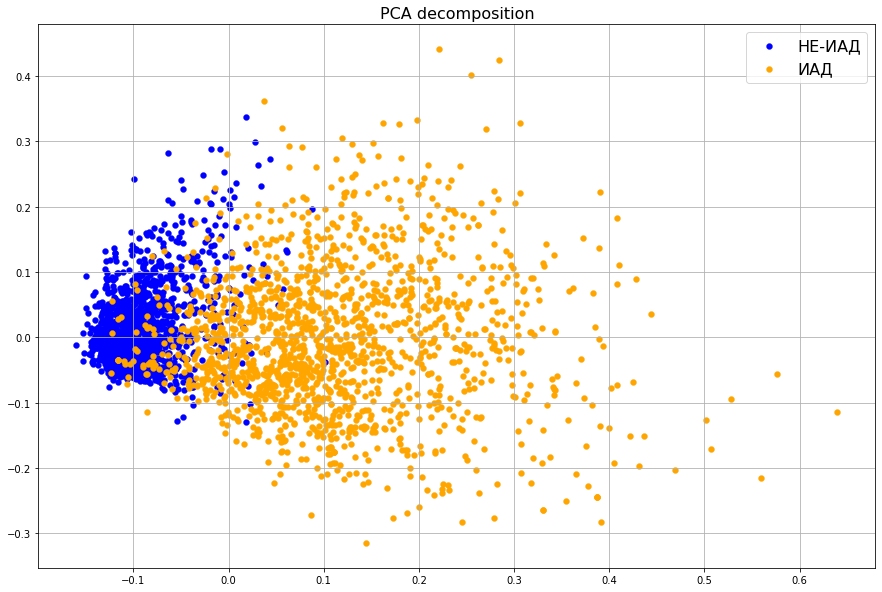

In [128]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[labels == 0, 0], X_pca[labels == 0, 1], c='blue', label='НЕ-ИАД', linewidths=0.3)
plt.scatter(X_pca[labels == 1, 0], X_pca[labels == 1, 1], c = 'orange', label='ИАД', linewidths=0.3)

plt.title('PCA decomposition', fontsize=16)
plt.grid(True)
plt.legend(fontsize = 16);

### t-SNE

In [34]:
tsne = TSNE(n_components=2, perplexity=500)

In [35]:
X_tsne = tsne.fit_transform(text_data_bow)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


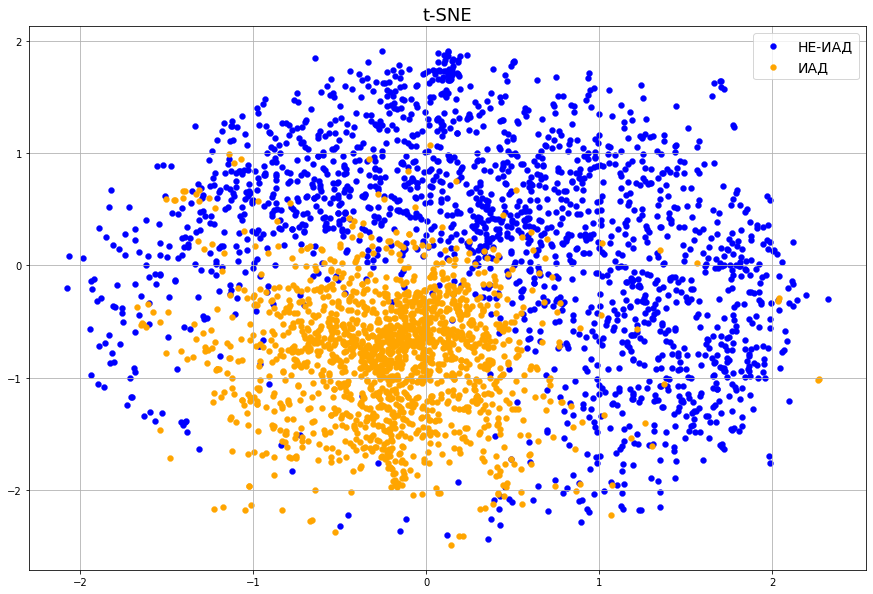

In [36]:
plt.figure(figsize=(15,10))

plt.scatter(X_tsne[labels == 0, 0], X_tsne[labels == 0, 1], c='blue', label='НЕ-ИАД', linewidths=0.3)
plt.scatter(X_tsne[labels == 1, 0], X_tsne[labels == 1, 1], c = 'orange', label='ИАД', linewidths=0.3)

plt.title('t-SNE', fontsize=18)
plt.grid(True)
plt.legend(fontsize = 14);

## Классификация

In [37]:
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(text_data_bow, labels, test_size=0.2, random_state=42)

text_data_bow.shape, X_tfidf_train.shape, X_tfidf_test.shape

((3419, 8895), (2735, 8895), (684, 8895))

### Логистическая регрессия

In [168]:
if os.path.exists('tfidf_regr_clf.joblib'):
    best_regr = load('tfidf_regr_clf.joblib') 
    
else:
    regr_clf = LogisticRegression()
    
    gridcv_params = {'C': np.linspace(0.01, 2.0, 20), 'max_iter': range(40, 200, 20)}
    regr_gridcv = GridSearchCV(regr_clf, gridcv_params)
    regr_gridcv.fit(X_tfidf_train, y_train)
    
    print(f'Best Logistic Regression params are: {regr_gridcv.best_params_}')
    best_regr = regr_gridcv.best_estimator_

In [178]:
y_pred_proba = best_regr.predict_proba(X_tfidf_test)
y_pred = best_regr.predict(X_tfidf_test)

In [179]:
dump(best_regr, 'tfidf_regr_clf.joblib') 

['tfidf_regr_clf.joblib']

### Логистическая регрессия. Критерии качества

In [180]:
regr_precision = precision_score(y_test, y_pred)
regr_recall = recall_score(y_test, y_pred)

regr_f1 = f1_score(y_test, y_pred)

In [181]:
print('Точность:', regr_precision)
print('Полнота:', regr_recall)
print('F1 мера:', regr_f1)

Точность: 0.978494623655914
Полнота: 0.8950819672131147
F1 мера: 0.934931506849315


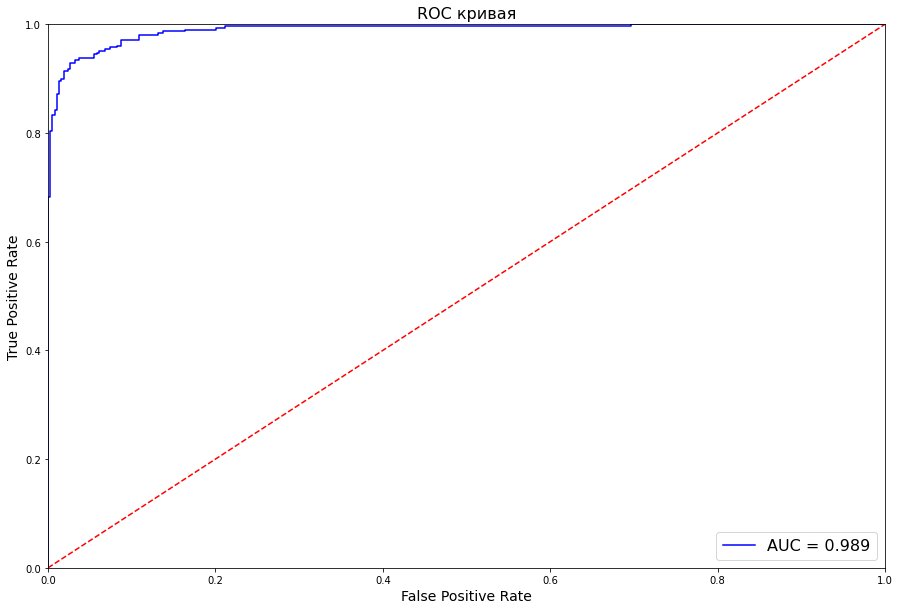

In [183]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

### K - ближайших соседей

In [185]:
if os.path.exists('tfidf_knn_clf.joblib'):
    best_neigh = load('tfidf_knn_clf.joblib') 
    
else:
    neigh = KNeighborsClassifier()

    neigh_params = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
    neigh_gridcv = GridSearchCV(neigh, neigh_params)
    neigh_gridcv.fit(X_tfidf_train, y_train)
    
    print(f'Best KNN params are: {neigh_gridcv.best_params_}')
    best_neigh = neigh_gridcv.best_estimator_

In [186]:
y_pred = best_neigh.predict(X_tfidf_test)
y_pred_proba = best_neigh.predict_proba(X_tfidf_test)

In [187]:
dump(best_neigh, 'tfidf_knn_clf.joblib') 

['tfidf_knn_clf.joblib']

### KNN. Критерии качества

In [188]:
knn_precision = precision_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)

knn_f1 = f1_score(y_test, y_pred)

In [189]:
print('Точность:', knn_precision)
print('Полнота:', knn_recall)
print('F1 мера:', knn_f1)

Точность: 0.729381443298969
Полнота: 0.9278688524590164
F1 мера: 0.8167388167388167


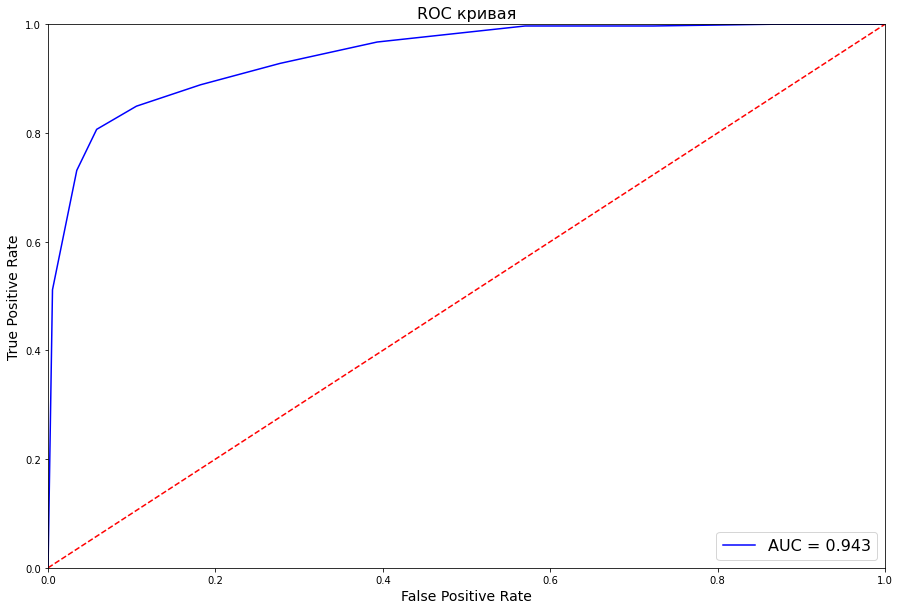

In [190]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

### Случайный лес

In [191]:
if os.path.exists('tfidf_forest_clf.joblib'):
    best_forest = load('tfidf_forest_clf.joblib') 
    
else:
    forest = RandomForestClassifier()
    forest_params = {'n_estimators': range(50, 250, 50), 'max_depth': range(1, 14, 2)}
    
    forest_gridcv = GridSearchCV(forest, forest_params)
    forest_gridcv.fit(X_tfidf_train, y_train)
    
    print(f'Best forest params are: {forest_gridcv.best_params_}')
    best_forest = forest_gridcv.best_estimator_

In [192]:
y_pred = best_forest.predict(X_tfidf_test)
y_pred_proba = best_forest.predict_proba(X_tfidf_test)

In [193]:
dump(best_forest, 'tfidf_forest_clf.joblib') 

['tfidf_forest_clf.joblib']

### Случайный лес. Критерии качества

In [194]:
forest_precision = precision_score(y_test, y_pred)
forest_recall = recall_score(y_test, y_pred)

forest_f1 = f1_score(y_test, y_pred)

In [195]:
print('Точность:', forest_precision)
print('Полнота:', forest_recall)
print('F1 мера:', forest_f1)

Точность: 0.9858156028368794
Полнота: 0.9114754098360656
F1 мера: 0.9471890971039182


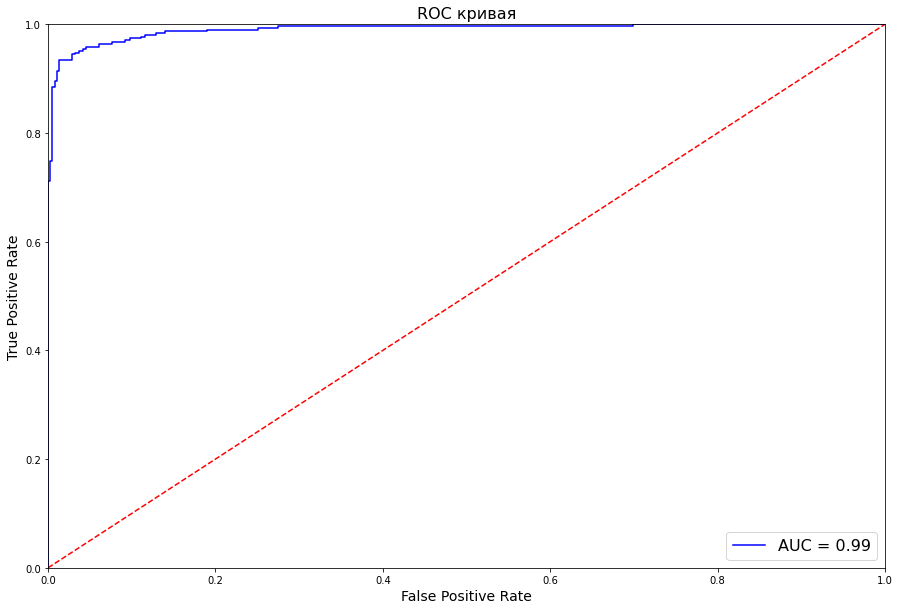

In [196]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

# Word2Vec

## Представление данных в виде векторов

In [57]:
w2v_texts = text_data.annotation.apply(lambda x: drop_bads(list(x)))

In [58]:
w2v_texts = w2v_texts.apply(lambda words: [stemmer.stem(word) for word in words]) ### Нужен ли стемминг???

In [59]:
w2v_model = Word2Vec(w2v_texts,
                    vector_size=100,
                    window=5,
                    min_count=2)

In [60]:
words = set(w2v_model.wv.index_to_key)

w2v_texts = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in w2v_texts])

C:\Users\Павел\AppData\Local\Temp\ipykernel_12132\2337299342.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w2v_texts = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in w2v_texts])


In [61]:
w2v_vectors = []
for v in w2v_texts:
    if v.size:
        w2v_vectors.append(v.mean(axis=0))
    else:
        w2v_vectors.append(np.zeros(100, dtype=float))

In [62]:
tfidf_name_keywords = (text_data['name'].apply(list) + text_data['keywords'].apply(list)).apply(lambda x: drop_bads(list(x)))

In [63]:
tfidf_name_keywords = tfidf_name_keywords.apply(lambda words: [stemmer.stem(word) for word in words])

In [64]:
vectorizer = TfidfVectorizer()
tfidf_name_keywords = vectorizer.fit_transform(tfidf_name_keywords.apply(' '.join))

In [65]:
np.array(tfidf_name_keywords.todense()).shape

(3419, 6160)

In [66]:
w2v_data = np.concatenate((w2v_vectors, np.array(tfidf_name_keywords.todense())), axis=1)

In [67]:
w2v_data.shape

(3419, 6260)

## Визуализация

### PCA decomposition

In [68]:
pca = PCA(n_components=2,
                random_state=42)

In [69]:
w2v_pca = pca.fit_transform(w2v_data)

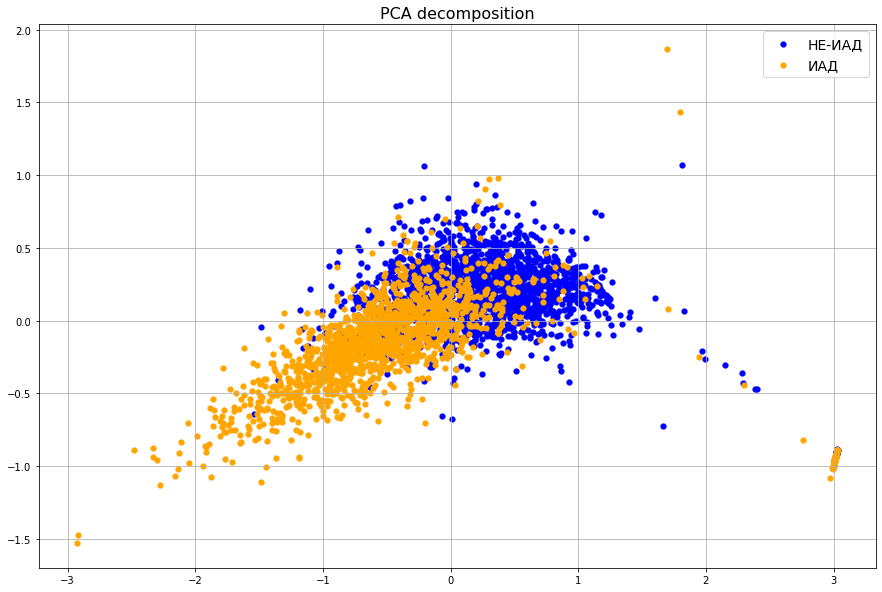

In [70]:
plt.figure(figsize=(15,10))

plt.scatter(w2v_pca[labels == 0, 0], w2v_pca[labels == 0, 1], c='blue', label='НЕ-ИАД', linewidths=0.2)
plt.scatter(w2v_pca[labels == 1, 0], w2v_pca[labels == 1, 1], c = 'orange', label='ИАД', linewidths=0.2)

plt.title('PCA decomposition', fontsize=16)
plt.grid(True)
plt.legend(fontsize = 14);

In [71]:
pca.explained_variance_ratio_

array([0.41285218, 0.06659977])

### t-SNE

In [72]:
tsne = TSNE(n_components=2, perplexity=300)

w2v_tsne = tsne.fit_transform(w2v_data)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


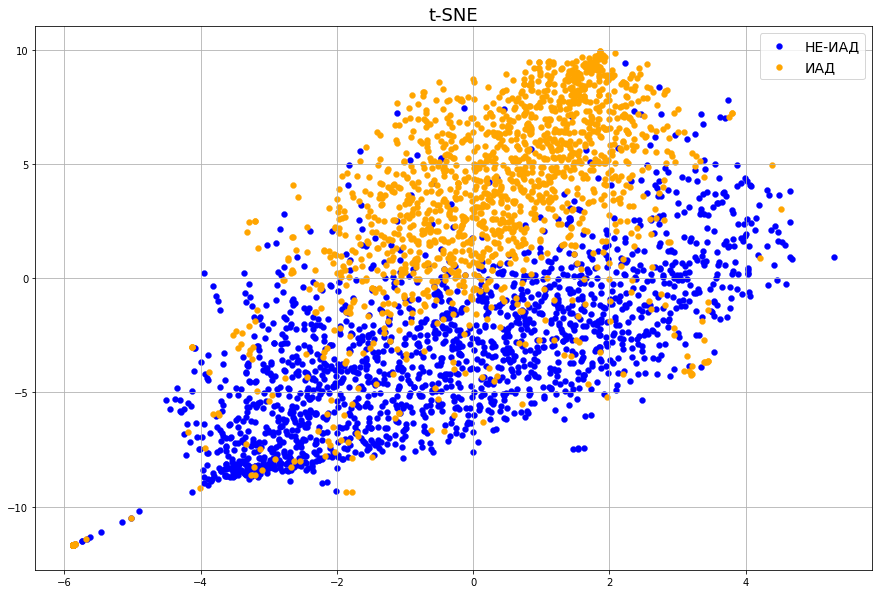

In [73]:
plt.figure(figsize=(15,10))

plt.scatter(w2v_tsne[labels == 0, 0], w2v_tsne[labels == 0, 1], c='blue', label='НЕ-ИАД', linewidths=0.3)
plt.scatter(w2v_tsne[labels == 1, 0], w2v_tsne[labels == 1, 1], c = 'orange', label='ИАД', linewidths=0.3)

plt.title('t-SNE', fontsize=18)
plt.grid(True)
plt.legend(fontsize = 14);

## Классификация

In [74]:
X_w2v_train, X_w2v_test, y_train, y_test = train_test_split(w2v_data, labels, test_size=0.2, random_state=42)

len(w2v_data), len(X_w2v_train), len(X_w2v_test)

(3419, 2735, 684)

### Логистическая регрессия

In [203]:
if os.path.exists('w2v_regr_clf.joblib'):
    best_regr = load('w2v_regr_clf.joblib') 
    
else:
    regr_clf = LogisticRegression()
    
    gridcv_params = {'C': np.linspace(0.01, 2.0, 10), 'max_iter': range(40, 200, 30)}
    regr_gridcv = GridSearchCV(regr_clf, gridcv_params)
    regr_gridcv.fit(X_w2v_train, y_train)
    
    print(f'Best Logistic Regression params are: {regr_gridcv.best_params_}')
    best_regr = regr_gridcv.best_estimator_

In [204]:
y_pred = best_regr.predict(X_w2v_test)
y_pred_proba = best_regr.predict_proba(X_w2v_test)

In [205]:
dump(best_regr, 'w2v_regr_clf.joblib') 

['w2v_regr_clf.joblib']

### Логистическая регрессия. Критерии качества

In [206]:
regr_precision = precision_score(y_test, y_pred)
regr_recall = recall_score(y_test, y_pred)

regr_f1 = f1_score(y_test, y_pred)

In [207]:
print('Точность:', regr_precision)
print('Полнота:', regr_recall)
print('F1 мера:', regr_f1)

Точность: 0.965034965034965
Полнота: 0.9049180327868852
F1 мера: 0.934010152284264


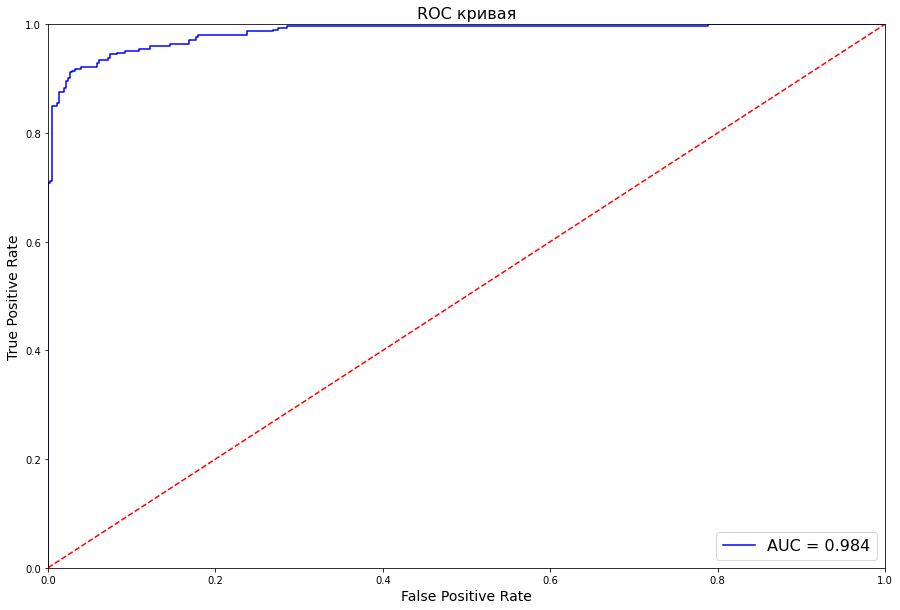

In [209]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

### K ближайших соседей

In [197]:
if os.path.exists('w2v_knn_clf.joblib'):
    best_neigh = load('w2v_knn_clf.joblib') 
    
else:
    neigh = KNeighborsClassifier()

    neigh_params = {'n_neighbors': range(1, 50, 7), 'weights': ['uniform', 'distance']}
    neigh_gridcv = GridSearchCV(neigh, neigh_params)
    neigh_gridcv.fit(X_w2v_train, y_train)
    
    print(f'Best KNN params are: {neigh_gridcv.best_params_}')
    best_neigh = neigh_gridcv.best_estimator_

In [198]:
y_pred = best_neigh.predict(X_w2v_test)
y_pred_proba = best_neigh.predict_proba(X_w2v_test)

In [199]:
dump(best_neigh, 'w2v_knn_clf.joblib')

['w2v_knn_clf.joblib']

### KNN. Критерии качества


In [200]:
knn_precision = precision_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)

knn_f1 = f1_score(y_test, y_pred)

In [201]:
print('Точность:', knn_precision)
print('Полнота:', knn_recall)
print('F1 мера:', knn_f1)

Точность: 0.8062678062678063
Полнота: 0.9278688524590164
F1 мера: 0.8628048780487804


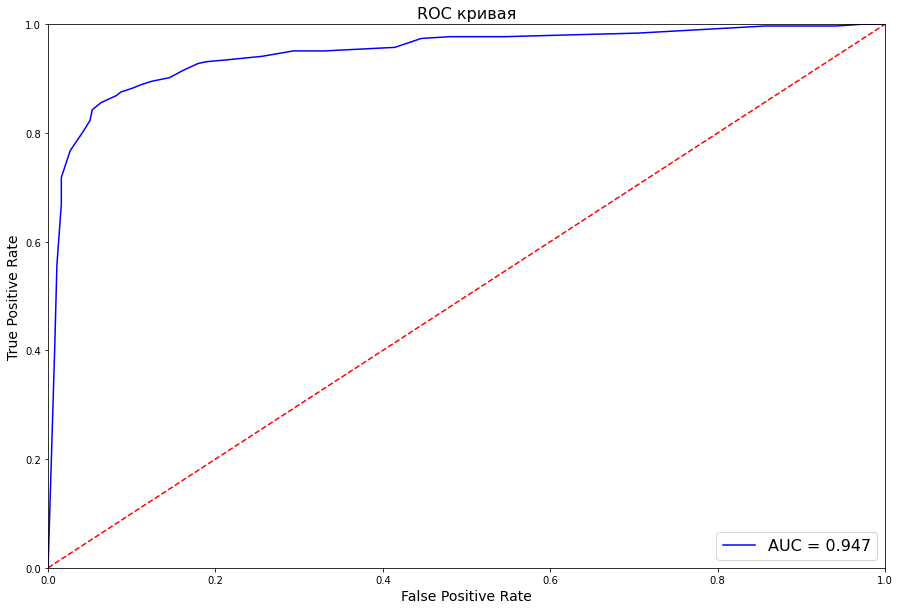

In [202]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

### Случайный лес

In [210]:
if os.path.exists('w2v_forest_clf.joblib'):
    best_forest = load('w2v_forest_clf.joblib') 
    
else:
    forest = RandomForestClassifier()
    forest_params = {'n_estimators': range(50, 250, 50), 'max_depth': range(1, 14, 2)}
    
    forest_gridcv = GridSearchCV(forest, forest_params)
    forest_gridcv.fit(X_w2v_train, y_train)
    
    print(f'Best forest params are: {forest_gridcv.best_params_}')
    best_forest = forest_gridcv.best_estimator_

In [211]:
y_pred = best_forest.predict(X_w2v_test)
y_pred_proba = best_forest.predict_proba(X_w2v_test)

In [212]:
dump(best_forest, 'w2v_forest_clf.joblib')

['w2v_forest_clf.joblib']

### Случайный лес. Критерии качества


In [213]:
forest_precision = precision_score(y_test, y_pred)
forest_recall = recall_score(y_test, y_pred)

forest_f1 = f1_score(y_test, y_pred)

In [214]:
print('Точность:', forest_precision)
print('Полнота:', forest_recall)
print('F1 мера:', forest_f1)

Точность: 0.9105960264900662
Полнота: 0.9016393442622951
F1 мера: 0.9060955518945635


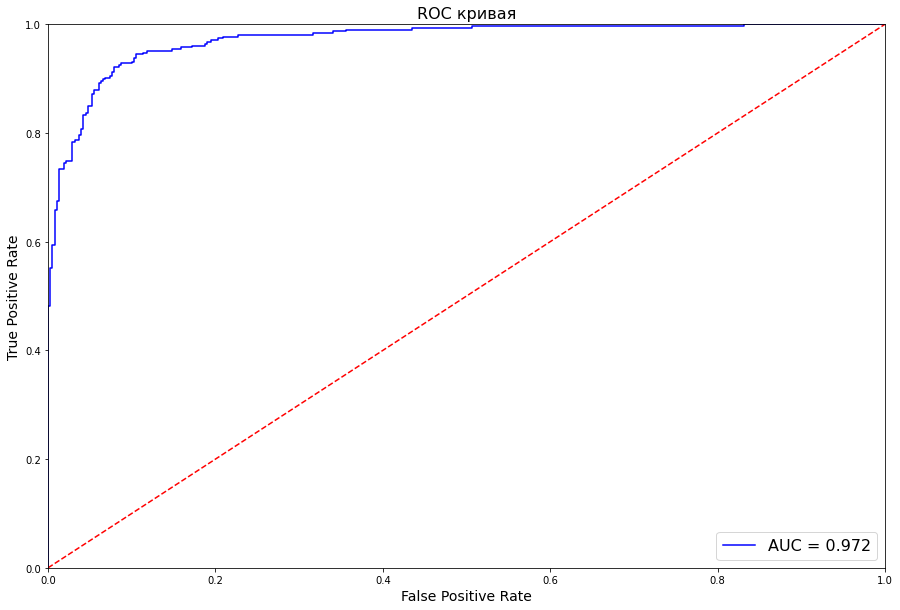

In [215]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

# FastText

## Представление данных в виде векторов

In [129]:
ft_texts = text_data.annotation.apply(lambda x: drop_bads(list(x)))

In [130]:
ft_texts.apply(' '.join).head(2)

0    статья приводиться описание система подготовка квазиокончательный данные стандарт интермагнета отличие окончательный данные ранний год измерение дать предоставлять описать система доступный сутки выполнение последний серия абсолютный наблюдение квазиокончательный дать находить применение моделирование быстрый вариация главное магнитный поле земля расчёт индекс геомагнитный активность работа приводиться анализ качество получать данные путём сравнение окончательный данные интермагнета сравнение данные получить модель показать качество квазиокончательный данные получить предложить методика автоматизированный алгоритм сравнимый качество который обеспечиваться традиционный подход подготовка окончательный данные стандарт интермагнета
1                                                                                                                                                                                                                                                                

In [131]:
fasttext_model = FastText(ft_texts,
                    vector_size=100,
                    window=5,
                    min_count=2)

In [132]:
fasttext_model.build_vocab(ft_texts)

In [133]:
fasttext_model.train(
    ft_texts,
    epochs=fasttext_model.epochs,
    total_examples=fasttext_model.corpus_count,
    total_words=fasttext_model.corpus_total_words
)

print(fasttext_model)

FastText<vocab=7484, vector_size=100, alpha=0.025>


In [134]:
words = set(fasttext_model.wv.index_to_key)

ft_vectors = np.array([np.array([fasttext_model.wv[i] for i in ls if i in words]) for ls in ft_texts])

C:\Users\Павел\AppData\Local\Temp\ipykernel_12132\1023156916.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ft_vectors = np.array([np.array([fasttext_model.wv[i] for i in ls if i in words]) for ls in ft_texts])


In [135]:
ft_texts = []
for v in ft_vectors:
    if v.size:
        ft_texts.append(v.mean(axis=0))
    else:
        ft_texts.append(np.zeros(100, dtype=float))

In [136]:
np.array(ft_texts).shape

(3419, 100)

In [137]:
ft_data = np.concatenate([ft_texts, tfidf_name_keywords.todense()], axis=1)

## Визуализация

### PCA decomposition

In [138]:
pca = PCA(n_components=2,
                random_state=42)

In [139]:
ft_pca = pca.fit_transform(ft_data)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


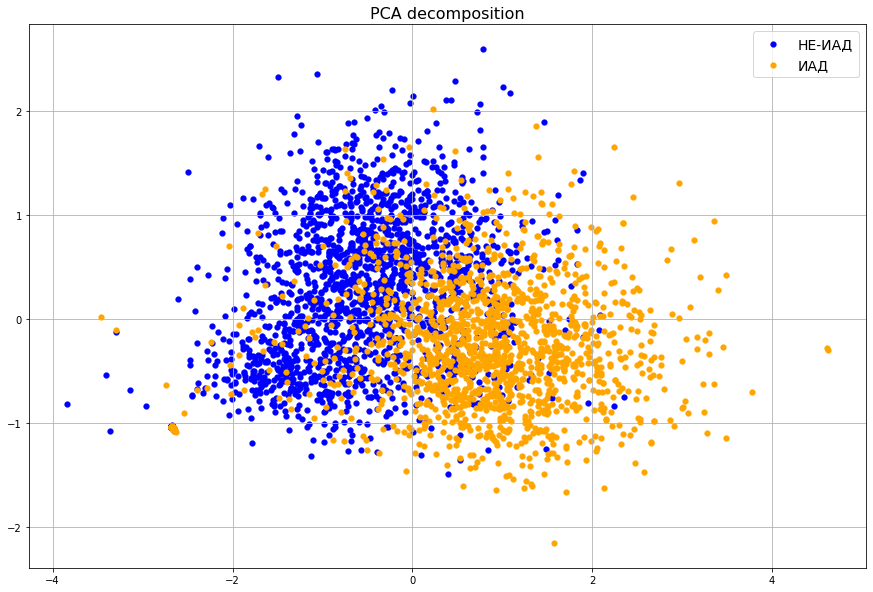

In [140]:
plt.figure(figsize=(15,10))

plt.scatter(ft_pca[labels == 0, 0], ft_pca[labels == 0, 1], c='blue', label='НЕ-ИАД', linewidths=0.2)
plt.scatter(ft_pca[labels == 1, 0], ft_pca[labels == 1, 1], c = 'orange', label='ИАД', linewidths=0.2)

plt.title('PCA decomposition', fontsize=16)
plt.grid(True)
plt.legend(fontsize = 14);

In [141]:
pca.explained_variance_ratio_

array([0.38027996, 0.12894572])

### t-SNE

In [142]:
tsne = TSNE(n_components=2, perplexity=300)

ft_tsne = tsne.fit_transform(ft_data)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


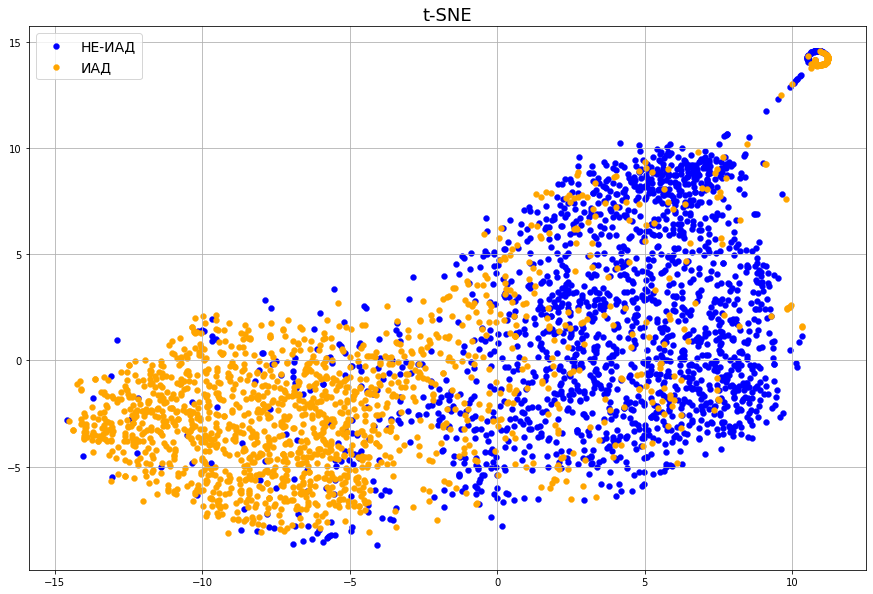

In [143]:
plt.figure(figsize=(15,10))

plt.scatter(ft_tsne[labels == 0, 0], ft_tsne[labels == 0, 1], c='blue', label='НЕ-ИАД', linewidths=0.3)
plt.scatter(ft_tsne[labels == 1, 0], ft_tsne[labels == 1, 1], c = 'orange', label='ИАД', linewidths=0.3)

plt.title('t-SNE', fontsize=18)
plt.grid(True)
plt.legend(fontsize = 14);

## Классификация

In [147]:
X_ft_train, X_ft_test, y_train, y_test = train_test_split(ft_data, labels, test_size=0.2, random_state=42)

len(ft_data), len(X_ft_train), len(X_ft_test)

(3419, 2735, 684)

### Логистическая регрессия

In [216]:
if os.path.exists('ft_regr_clf.joblib'):
    best_regr = load('ft_regr_clf.joblib') 
    
else:
    regr_clf = LogisticRegression()
    
    gridcv_params = {'C': np.linspace(0.01, 2.0, 20), 'max_iter': range(40, 200, 20)}
    regr_gridcv = GridSearchCV(regr_clf, gridcv_params)
    regr_gridcv.fit(X_ft_train, y_train)
    
    print(f'Best Logistic Regression params are: {regr_gridcv.best_params_}')
    best_regr = regr_gridcv.best_estimator_

In [217]:
y_pred = best_regr.predict(X_ft_test)
y_pred_proba = best_regr.predict_proba(X_ft_test)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [218]:
dump(best_regr, 'ft_regr_clf.joblib') 

['ft_regr_clf.joblib']

### Логистическая регрессия. Критерии качества

In [219]:
regr_precision = precision_score(y_test, y_pred)
regr_recall = recall_score(y_test, y_pred)

regr_f1 = f1_score(y_test, y_pred)

In [220]:
print('Точность:', regr_precision)
print('Полнота:', regr_recall)
print('F1 мера:', regr_f1)

Точность: 0.975177304964539
Полнота: 0.9016393442622951
F1 мера: 0.9369676320272572


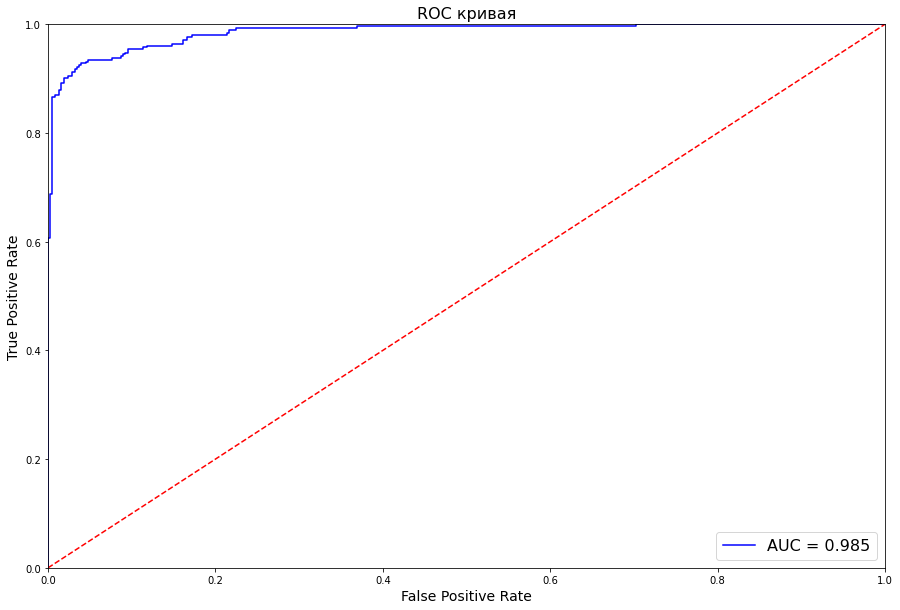

In [221]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

### K - ближайших соседей

In [222]:
if os.path.exists('ft_knn_clf.joblib'):
    best_neigh = load('ft_knn_clf.joblib') 
    
else:
    neigh = KNeighborsClassifier()

    neigh_params = {'n_neighbors': range(1, 100, 5), 'weights': ['uniform', 'distance']}
    neigh_gridcv = GridSearchCV(neigh, neigh_params)
    neigh_gridcv.fit(X_ft_train, y_train)
    
    print(f'Best KNN params are: {neigh_gridcv.best_params_}')
    best_neigh = neigh_gridcv.best_estimator_

In [223]:
y_pred = best_neigh.predict(X_ft_test)
y_pred_proba = best_neigh.predict_proba(X_ft_test)

C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [224]:
dump(best_neigh, 'ft_knn_clf.joblib') 

['ft_knn_clf.joblib']

### KNN. Критерии качества

In [225]:
knn_precision = precision_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)

knn_f1 = f1_score(y_test, y_pred)

In [226]:
print('Точность:', knn_precision)
print('Полнота:', knn_recall)
print('F1 мера:', knn_f1)

Точность: 0.8071216617210683
Полнота: 0.8918032786885246
F1 мера: 0.8473520249221185


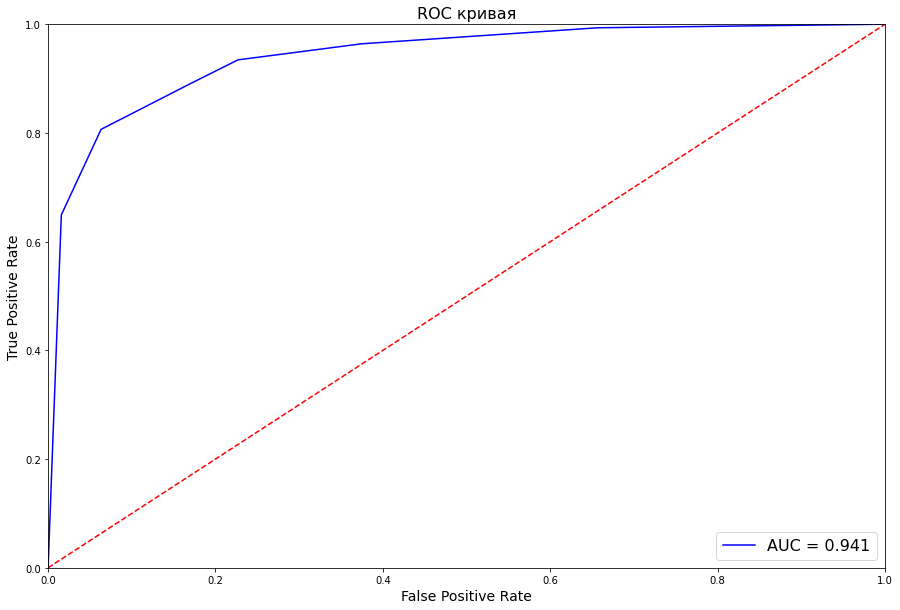

In [227]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

### Случайный лес

In [228]:
if os.path.exists('ft_forest_clf.joblib'):
    best_forest = load('ft_forest_clf.joblib') 
    
else:
    forest = RandomForestClassifier()
    forest_params = {'n_estimators': range(50, 250, 50), 'max_depth': range(1, 14, 2)}
    
    forest_grid = GridSearchCV(forest, forest_params)
    forest_grid.fit(X_ft_train, y_train)
    
    print(f'Best forest params are: {forest_grid.best_params_}')
    best_forest = forest_grid.best_estimator_

In [229]:
y_pred = best_forest.predict(X_ft_test)
y_pred_proba = best_forest.predict_proba(X_ft_test)


C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [230]:
dump(best_forest, 'ft_forest_clf.joblib') 

['ft_forest_clf.joblib']

### Случайный лес. Критерии качества

In [231]:
forest_precision = precision_score(y_test, y_pred)
forest_recall = recall_score(y_test, y_pred)

forest_f1 = f1_score(y_test, y_pred)

In [232]:
print('Точность:', forest_precision)
print('Полнота:', forest_recall)
print('F1 мера:', forest_f1)

Точность: 0.9444444444444444
Полнота: 0.8918032786885246
F1 мера: 0.9173693086003373


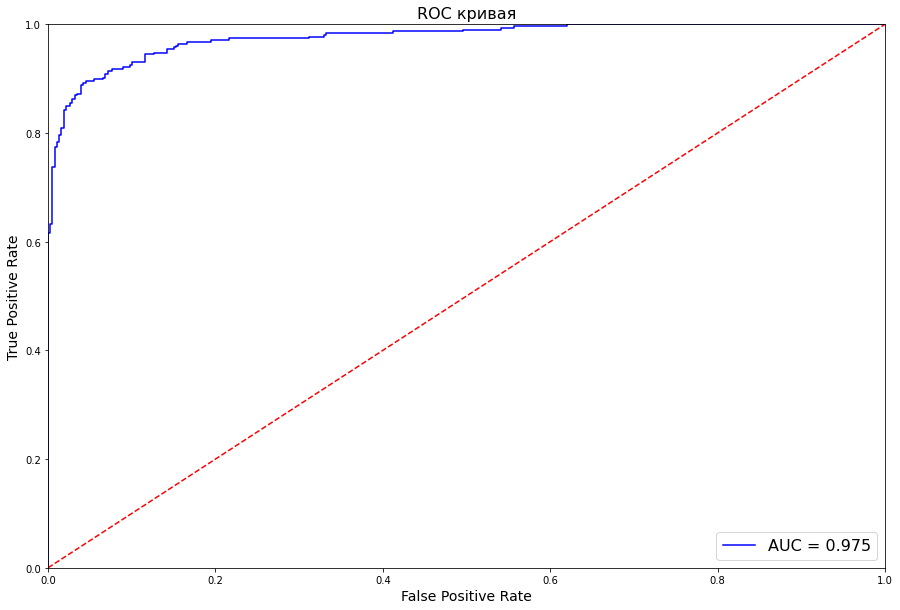

In [233]:
#ROC кривая
plt.figure(figsize = (15, 10))

fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC кривая', fontsize=16)
plt.plot(fpr, tpr, 'b', label=f'AUC = {round(roc_auc, 3)}')
plt.legend(loc='lower right', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()